In [1]:
from google.protobuf.json_format import MessageToDict
import pandas as pd
import math
import ast
import geopandas as gpd
from shapely.geometry import LineString, Point
import tomtomtrafficflowTile_pb2
import os
import matplotlib.pyplot as plt
import numpy as np
from utils_TomTom import *

In [2]:
# Valores globales
zoom_level = 16
tile = tomtomtrafficflowTile_pb2.Tile()
tiles_largo = 3
tiles_ancho = 3

month = "junio"
# Tengo todos los datos de un dia, en todas las estaciones
ruta_raiz ="C:/Users/valer/Documents/CIC/doctorado/air_pollution_data/vectores/junio/2024-06-12"
dataframes = []
all_points = []
# Itera sobre todas las carpetas y subcarpetas
for carpeta_actual, carpetas, archivos in os.walk(ruta_raiz):
    # Itera sobre todos los archivos en la carpeta actual
    for nombre_archivo in archivos:
        # Forma la ruta completa del archivo
        ruta_archivo = os.path.join(carpeta_actual, nombre_archivo)
        
        # Verifica si el archivo tiene una extensión específica (por ejemplo, .xlsx)
        if nombre_archivo.endswith('.pbf'):
            # Lee el archivo y agrega el DataFrame a la lista
            nombre = nombre_archivo.split("_")
            zoom_level = int(nombre[2])
            xTile = int(nombre[3])
            yTile = int(nombre[4])
            fecha = nombre[7]+"-"+nombre[6]+"-"+nombre[5]
            ultimo = nombre[10].split(".")
            hora = nombre[8]+":"+nombre[9]+":"+ultimo[0]
            estacion = nombre[0]
            dataframe, points = conversion_vectorDATAFRAME(ruta_archivo, zoom_level, xTile, yTile, fecha, hora, estacion)

            if len(dataframe)>0:
                dataframes.append(dataframe)
                all_points.append(points)

# Combina todos los DataFrames en uno solo
df_completo = pd.concat(dataframes, ignore_index=True)

In [3]:
# Tengo los datos de un día en una sola estación
station = "PED"
df_station = df_completo[df_completo.station==station]

In [7]:
df_station[0:100].to_csv("PED_segment.csv")

In [5]:
times = list(set(df_station.time))
df_station_timestamp = df_station[df_station.time == times[0]]
for i in times:
    df_station_timestamp = df_station[df_station.time == i]
    print(len(df_station_timestamp))

172
174
173
179
178
178
172
164
177
171
178
164
172
168
174
177
177
175
164


In [8]:
streets_unique = []
for street in df_station.coordinates:
    if street not in streets_unique:
        streets_unique.append(street)
streets_ID = {i:string for i, string in enumerate(streets_unique)}

# Crear un diccionario que asigne un número a cada calle única. La llave son las coordenadas que identifican cada calle
streets_dictionary = {str(string):i for i, string in enumerate(streets_unique)}


In [9]:
def obtener_id(coordenadas):
    coord_str = str(coordenadas)
    #return int(streets_dictionary.get(coord_str, None))
    id_value = streets_dictionary.get(coord_str, None)

    # Convertir a int si existe un valor, de lo contrario devolver None
    return int(id_value) if id_value is not None else None


# Agregar una nueva columna 'IDs' al DataFrame
df_station['IDs'] = df_station['coordinates'].apply(obtener_id)

C:\Users\valer\AppData\Local\Temp\ipykernel_19968\2227929680.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_station['IDs'] = df_station['coordinates'].apply(obtener_id)


In [207]:
df_station

,type,road_type,traffic_level,traffic_road_coverage,road_closure,road_category,road_subcategory,left_hand_traffic,coordinates,date,time,station,IDs
2203,LINESTRING,NaN,0.290,full,NaN,tertiary,connecting,NaN,"[[19.331878440818784, -99.20867666602135], [19...",12-06-2024,19:16:52,PED,0
2204,LINESTRING,NaN,0.338,full,NaN,tertiary,connecting,NaN,"[[19.330745810285784, -99.21040803194046], [19...",12-06-2024,19:16:52,PED,1
2205,LINESTRING,NaN,0.429,full,NaN,motorway,NaN,NaN,"[[19.331878440818784, -99.2106306552887], [19....",12-06-2024,19:16:52,PED,2
2206,LINESTRING,NaN,0.469,full,NaN,tertiary,connecting,NaN,"[[19.33161394944292, -99.20930832624435], [19....",12-06-2024,19:16:52,PED,3
2207,LINESTRING,NaN,0.517,full,NaN,tertiary,connecting,NaN,"[[19.331169755792548, -99.21137630939484], [19...",12-06-2024,19:16:52,PED,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...
63955,LINESTRING,NaN,1.000,one_side,NaN,street,local,NaN,"[[19.320477240378377, -99.2010498046875], [19....",12-06-2024,23:47:04,PED,105
63956,LINESTRING,NaN,1.000,one_side,NaN,street,local,NaN,"[[19.320477240378377, -99.2010498046875], [19....",12-06-2024,23:47:04,PED,105
63957,LINESTRING,NaN,1.000,one_side,NaN,street,local,NaN,"[[19.32151122681717, -99.19647261500359], [19....",12-06-2024,23:47:04,PED,106
63958,LINESTRING,NaN,1.000,one_side,NaN,street,local,NaN,"[[19.32151122681717, -99.19647261500359], [19....",12-06-2024,23:47:04,PED,106


In [43]:
len_streets = []
columnas = df_completo.columns
validated_streets = pd.DataFrame(columns = columnas )

import math

def haversine(lat1, lon1, lat2, lon2):
    R = 6371  # Radio de la Tierra en km
    dlat = math.radians(lat2 - lat1)
    dlon = math.radians(lon2 - lon1)
    a = (math.sin(dlat / 2) ** 2 +
         math.cos(math.radians(lat1)) * math.cos(math.radians(lat2)) * math.sin(dlon / 2) ** 2)
    c = 2 * math.atan2(math.sqrt(a), math.sqrt(1 - a))
    distance = R * c
    return distance

# Ejemplo de uso
#distancia = haversine(lat1, lon1, lat2, lon2)
#print(f"La distancia es: {distancia} km")



#for para cada calle
for i in range(len(df_completo)):
    street = df_completo.coordinates.iloc[i]
    #for por cada punto de cada calle
    for p in range(len(street)-1):
        len_street = 0
        lat1 = street[p][0]
        lon1 = street[p][1]
        lat2 = street[p+1][0]
        lon2 = street[p+1][1]
        #d = np.sqrt(np.power(y2-y1,2)+np.power(x2-x1,2))
        d = haversine(lat1, lon1, lat2, lon2)
        len_street = len_street + d
    len_streets.append(len_street)
df_completo["len_street"] = len_streets
umbral_len_street = 0.08
# Se filtran solo las calles que tengan una longitud de al menos 100 metros
df_filtrado = df_completo[df_completo.len_street > umbral_len_street]

In [11]:
#Vamos a crear una función para ver si hay coordenadas contenidas en otras coordenadas más grandes
def calle_contenida(s1,s2):
  contador = 0
  for coordenada1 in s1:
    for coordenada2 in s2:
      if coordenada1 == coordenada2:
        contador += 1
  if contador == len(s2):
    return True
  else:
    return False

In [12]:
#streets_unique = set(df_station.coordinates)
#streets = {i:string for i, string in enumerate(streets_unique)}

streets_unique = []
for street in df_station.coordinates:
    if street not in streets_unique:
        streets_unique.append(street)
streets = {i:string for i, string in enumerate(streets_unique)}

In [185]:
len(streets)

153

In [ ]:
ids = list(traffic_data.IDs)

# Crear el histograma
plt.figure(figsize=(8, 6))
plt.hist(ids, bins=len(set(ids)), edgecolor='black')

# Configurar el título y etiquetas
plt.title('Histograma de IDs de Coordenadas')
plt.xlabel('ID')
plt.ylabel('Frecuencia')

# Mostrar el gráfico
plt.show()

In [187]:
streets[0]

[[19.331878440818784, -99.20867666602135],
 [19.33161394944292, -99.20930832624435],
 [19.33156459459288, -99.20939683914185],
 [19.331500053635132, -99.20956045389175],
 [19.331458291838945, -99.20969322323799],
 [19.331431716150462, -99.20982599258423],
 [19.33142032656968, -99.20989036560059],
 [19.331407671479926, -99.21002984046936],
 [19.331406405970952, -99.21005800366402],
 [19.331407671479926, -99.21008616685867],
 [19.33141273351583, -99.2101277410984],
 [19.331463353874845, -99.21025514602661],
 [19.33151777076079, -99.21033963561058],
 [19.331543080940296, -99.21038120985031],
 [19.331592435790338, -99.2104509472847],
 [19.331631666568576, -99.21050325036049],
 [19.331701269562224, -99.21061053872108],
 [19.331767076028946, -99.21073257923126],
 [19.33180504129821, -99.21081304550171]]

In [ ]:
for i in streets:
    print(streets[i])

In [181]:
#Quitamos las calles que están contenidas en otras calles
unique_new_streets = []
for i in range(len(streets)):
  c = 0
  for j in range(i+1,len(streets)):
    if calle_contenida(streets[i],streets[j]):
      c += 1
  if c == 0:
    unique_new_streets.append(streets[i])

In [174]:
len(unique_new_streets)

130

In [4]:
dir = "C:/Users/valer/Documents/CIC/doctorado/A24/Tesis/Datos para compartir en DRIVE/Informacion estaciones.csv"
info_estaciones = pd.read_csv(dir, encoding="Latin1")

#EMCAS = ["PED", "FAC", "BJU", "NEZ", "SAC"]
EMCAS = ["PED"]
EMCAS_data = info_estaciones[info_estaciones["Key"].isin(EMCAS)]
EMCAS_data

,Key,Name,ID,O3,CO,SO2,NO2,PM10,PM25,Status,date,Alcaldía o municipio,State,Altitud (msnm),Latitude,Longitude,Domicilio,Página,Notas
32,PED,Pedregal,484090100127,4.0,2.0,4.0,3.0,3.0,3.0,Activa,12/05/2024,Álvaro Obregón,CDMX,2326,19.325146,-99.204136,"Cañada No. 370, Col. Jardines del Pedregal, C....",http://www.aire.cdmx.gob.mx/entornos/entorno_d...,NaN


In [31]:
df_station

,type,road_type,traffic_level,traffic_road_coverage,road_closure,road_category,road_subcategory,left_hand_traffic,coordinates,date,time,station,len_street
0,LINESTRING,NaN,0.400,full,NaN,tertiary,connecting,NaN,"[[19.280035796279765, -99.21359449625015], [19...",12-06-2024,19:15:00,AJM,0.031349
1,LINESTRING,NaN,0.766,full,NaN,tertiary,connecting,NaN,"[[19.27939144803043, -99.2120361328125], [19.2...",12-06-2024,19:15:00,AJM,0.036277
2,LINESTRING,NaN,0.970,full,NaN,tertiary,connecting,NaN,"[[19.279449679895794, -99.21237006783485], [19...",12-06-2024,19:15:00,AJM,0.038432
3,LINESTRING,NaN,1.000,full,NaN,tertiary,connecting,NaN,"[[19.279528166323022, -99.21234995126724], [19...",12-06-2024,19:15:00,AJM,0.035828
6,LINESTRING,NaN,1.000,one_side,NaN,street,minor_local,NaN,"[[19.274850628442298, -99.21680107712746], [19...",12-06-2024,19:15:00,AJM,0.005191
...,...,...,...,...,...,...,...,...,...,...,...,...,...
66167,LINESTRING,NaN,1.000,one_side,NaN,street,local,NaN,"[[19.521836356785332, -99.085693359375], [19.5...",12-06-2024,23:08:47,XAL,0.024136
66168,LINESTRING,NaN,1.000,one_side,NaN,street,local,NaN,"[[19.52333295275669, -99.08347114920616], [19....",12-06-2024,23:08:47,XAL,0.048114
66169,LINESTRING,NaN,1.000,one_side,NaN,tertiary,major_local,NaN,"[[19.52355289169167, -99.07916218042374], [19....",12-06-2024,23:08:47,XAL,0.045031
66170,LINESTRING,NaN,1.000,one_side,NaN,tertiary,major_local,NaN,"[[19.52355289169167, -99.07916218042374], [19....",12-06-2024,23:08:47,XAL,0.045031


In [44]:
df_station = df_filtrado

20:47:39


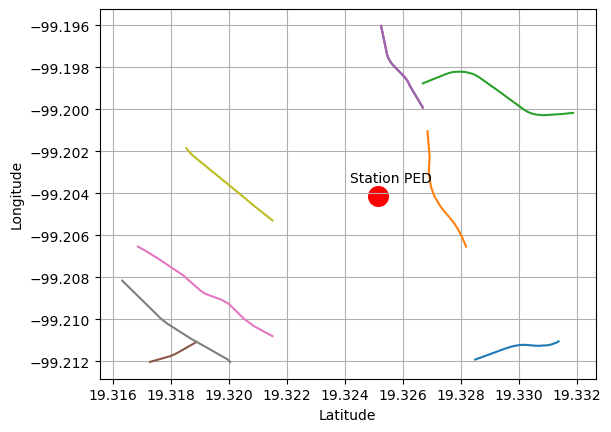

22:47:20


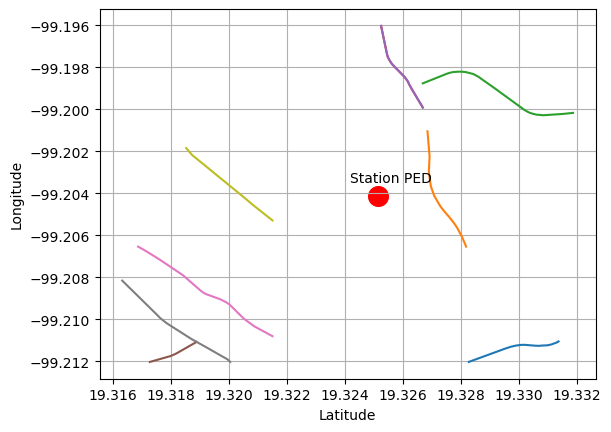

20:31:54


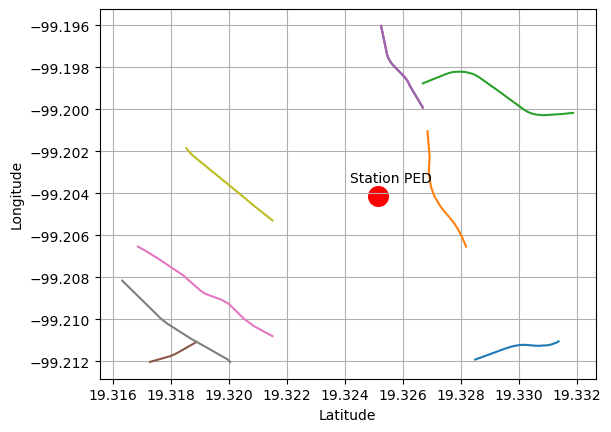

23:32:23


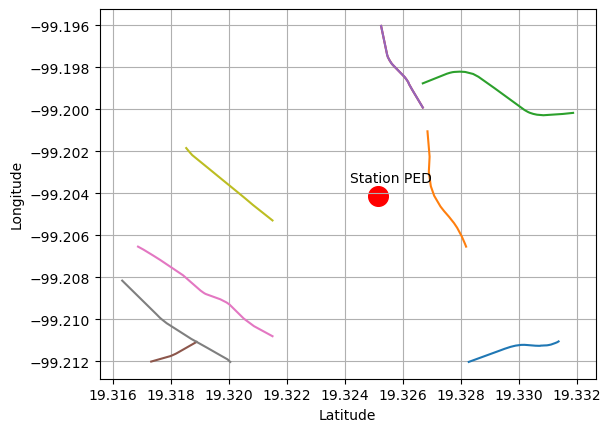

22:02:28


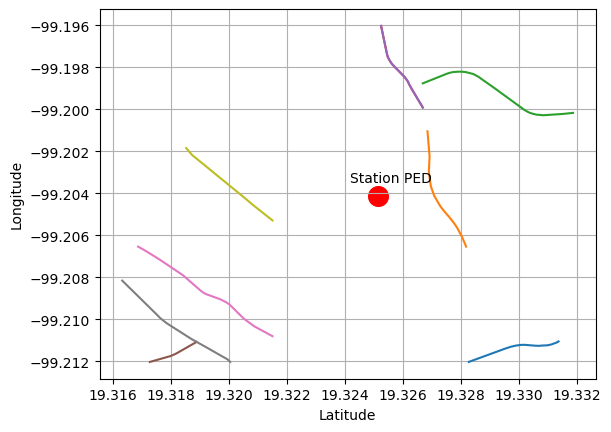

22:32:39


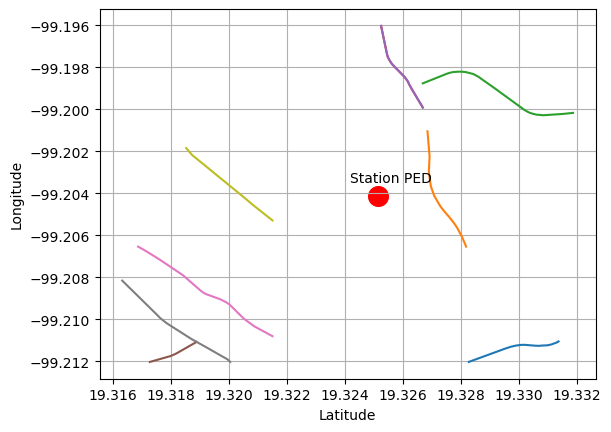

20:02:24


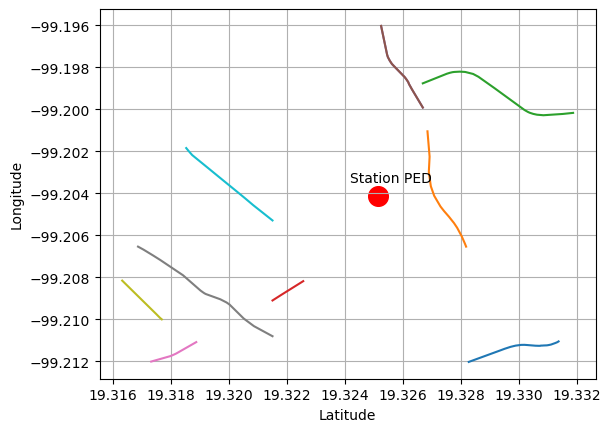

19:47:40


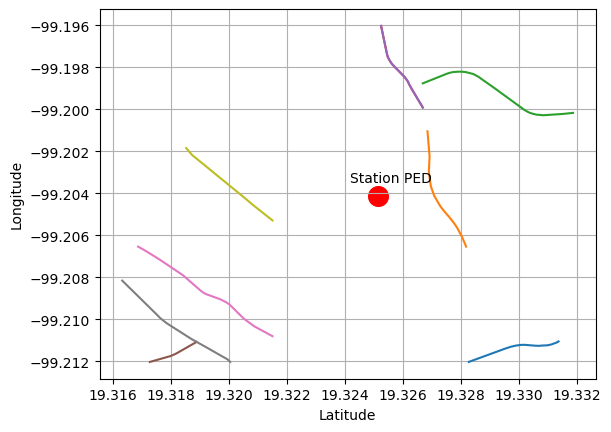

23:02:02


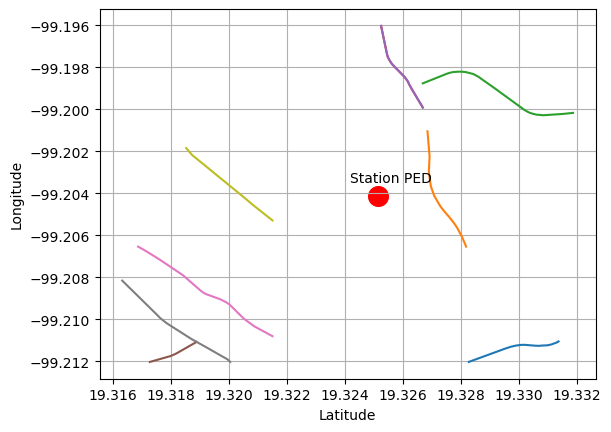

21:02:23


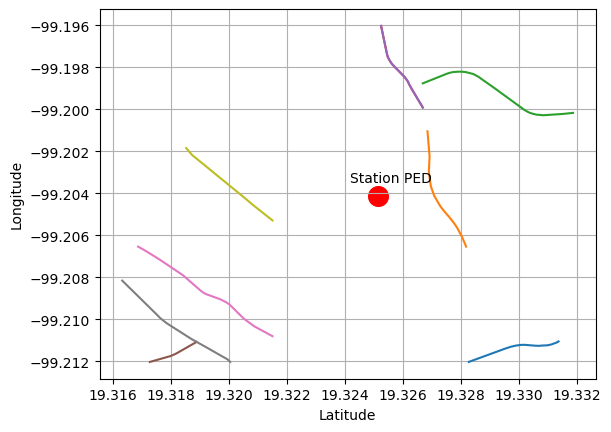

23:47:04


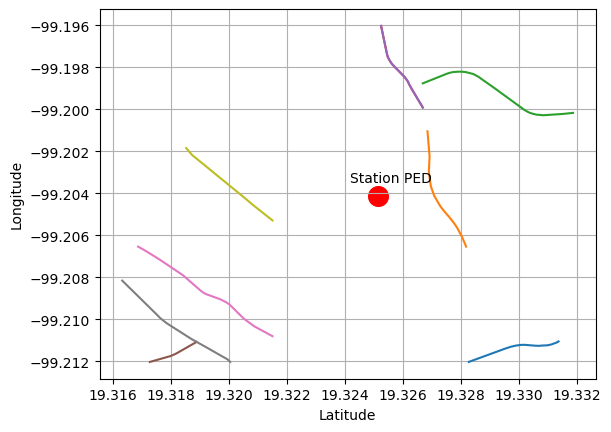

19:16:52


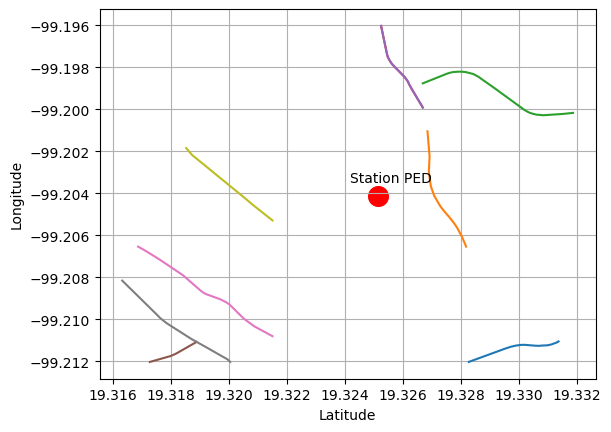

21:17:07


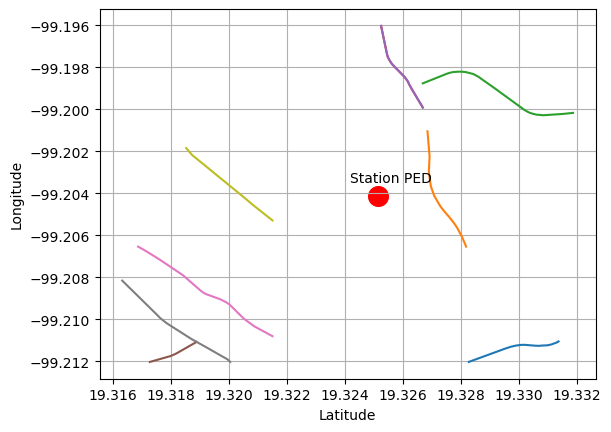

20:17:09


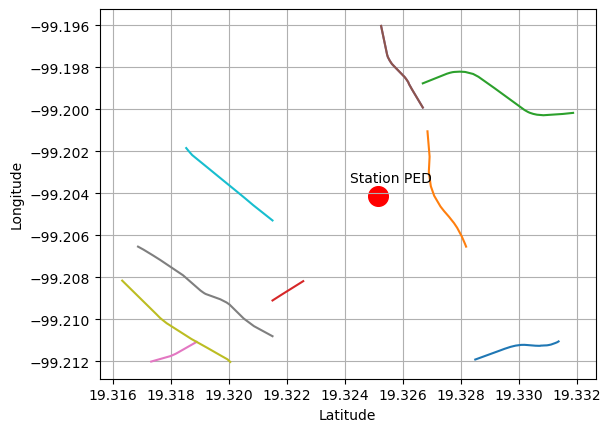

21:31:56


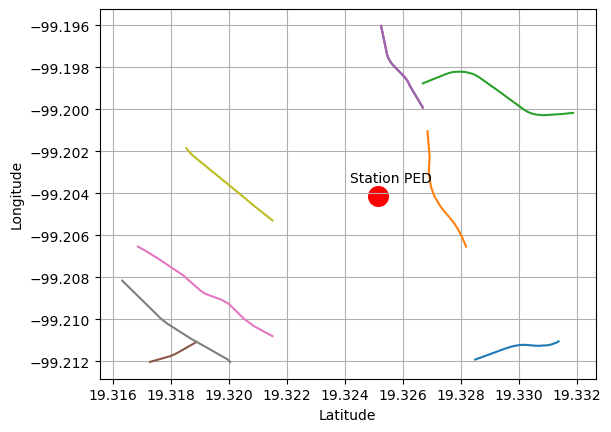

22:16:57


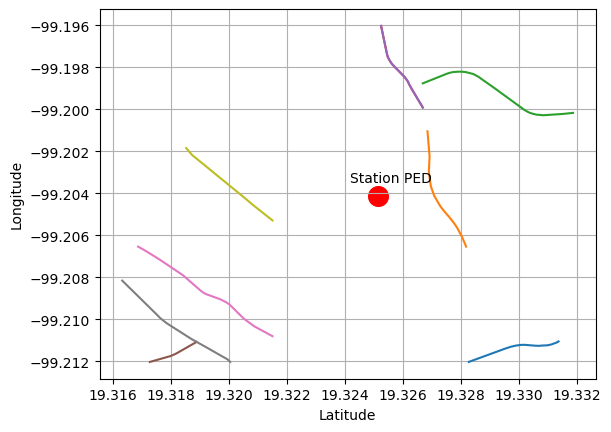

23:16:42


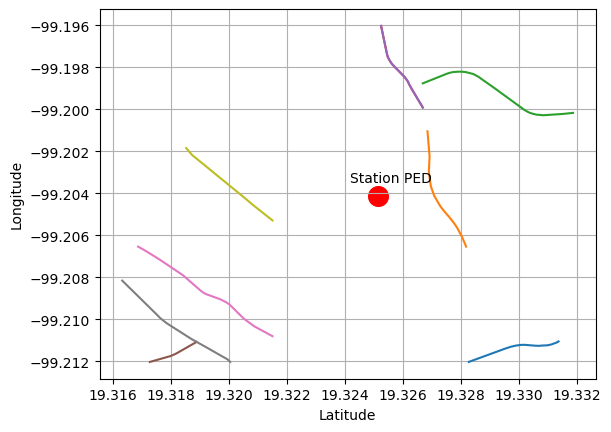

21:47:43


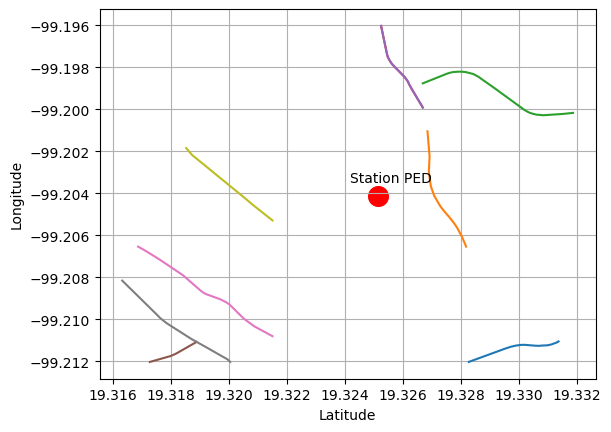

19:31:50


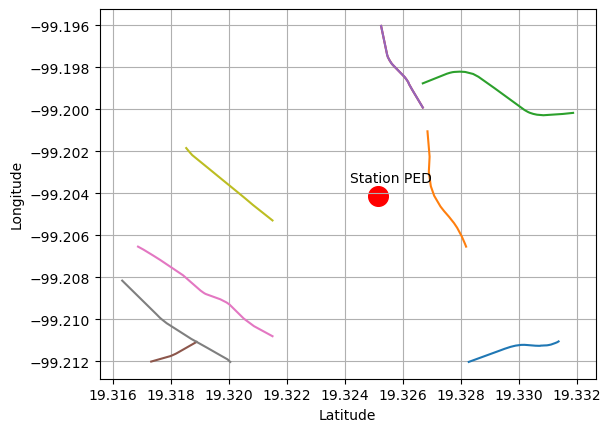

In [45]:
for station_name in EMCAS:
    for i in times:
        df_station_timestamp = df_station[df_station.time == i]
        streets_unique = []
        for street in df_station_timestamp.coordinates:
            if street not in streets_unique:
                streets_unique.append(street)
        #streets_unique = set(df_station_timestamp.coordinates)
        # Crear un diccionario que asigne un número a cada calle única
        streets = {i:string for i, string in enumerate(streets_unique)}
        all_points = []
        for row in range(len(streets)):
            #coordinates = ast.literal_eval(streets[row])
            coordinates = streets[row]
            all_points.append(coordinates)

        print(i)
        plt.figure()
        for coords in all_points:
            x = [punto[0] for punto in coords]
            y = [punto[1] for punto in coords]
            plt.plot(x, y)
        station_latitude = EMCAS_data[EMCAS_data["Key"]==station_name].Latitude.values[0]
        station_longitude = EMCAS_data[EMCAS_data["Key"]==station_name].Longitude.values[0]
        plt.scatter([station_latitude], [station_longitude], color='red', marker='o', s=200, label='SAC')
        name = "Station "+ station_name
        plt.annotate(name, (station_latitude, station_longitude), xytext=(-20, 10), textcoords='offset points', color='black')
        plt.grid(True)
        plt.xlabel('Latitude')
        plt.ylabel('Longitude')
        plt.show()
        


In [ ]:
def tileZXYToLatLon(z, x, y):
    MAX_ZOOM_LEVEL = 22

    if z > MAX_ZOOM_LEVEL or (z is None or not isinstance(z, (int, float))):
        raise ValueError(f"Zoom level value is out of range [0, {MAX_ZOOM_LEVEL}]")
    minXY = 0
    maxXY = int(2**z - 1)
    if x > maxXY or x < minXY or x is None or not isinstance(x, (int, float)):
        raise ValueError(f"Tile x value is out of range [0, {maxXY}]")

    if y > maxXY or y < minXY or y is None or not isinstance(y, (int, float)):
        raise ValueError(f"Tile y value is out of range [0, {maxXY}]")

    
    lon = (x / (2**z)) * 360.0 - 180.0
    n = math.pi - (2.0 * math.pi * y) / (2**z)
    lat = (180.0 / math.pi) * (math.atan(0.5 * (math.exp(n) - math.exp(-n))))
   
    return lat,lon
"""
"""
# Función para convertir coordenadas geodésicas a coordenadas de tiles
def lat_lon_to_tile_zxy(lat, lon, zoom_level):
    
    min_zoom_level = 0
    max_zoom_level = 22
    min_lat = -85.051128779807
    max_lat = 85.051128779806
    min_lon = -180.0
    max_lon = 180.0

    # Check input values of zoom level, latitude and longitude
    if (zoom_level is None or not isinstance(zoom_level, (int, float))
        or zoom_level < min_zoom_level
        or zoom_level > max_zoom_level ):
        
        raise ValueError(
            f"Zoom level value is out of range [{min_zoom_level}, {max_zoom_level}]"
        )

    if lat is None or not isinstance(lat, (int, float)) or lat < min_lat or lat > max_lat:
        raise ValueError(f"Latitude value is out of range [{min_lat}, {max_lat}]")

    if (lon is None or not isinstance(lon, (int, float))
        or lon < min_lon
        or lon > max_lon ):
        
        raise ValueError(f"Longitude value is out of range [{min_lon}, {max_lon}]")

    z = int(zoom_level)
    xy_tiles_count = 2**z
    x = int(((lon + 180.0) / 360.0) * xy_tiles_count)
    y = int(((1.0 - math.log( math.tan((lat * math.pi) / 180.0) + 1.0 / math.cos((lat * math.pi) / 180.0)) /math.pi)/ 2.0)* xy_tiles_count)

    return x,y

def transform(decodedTiles, zoom_level, xTile, yTile):
    lat_inicio, lon_inicio = tileZXYToLatLon(zoom_level, xTile, yTile)
    lat_fin, lon_fin = tileZXYToLatLon(zoom_level, xTile+1, yTile+1)

    # Calcular diferencias en latitud y longitud
    diff_lat =lat_fin-lat_inicio
    diff_lon =lon_fin-lon_inicio

    num_pixeles = 4096
    coordinates = []

    # Calcular incrementos por píxel
    inc_lat = diff_lat / num_pixeles
    inc_lon = diff_lon / num_pixeles
    for x,y in decodedTiles:
        lat_pixel = lat_inicio + (y * inc_lat)
        lon_pixel = lon_inicio + (x * inc_lon)
        coordinates.append((lon_pixel,lat_pixel))
    return coordinates

def decode_geometry(geometry):
    c = 0
    decodeTiles = []
    lines =[]
    decode_x = 0
    decode_y = 0
    while c < len(geometry):
        command_and_count = geometry[c]
        command = command_and_count & 0x7
        count = command_and_count >> 0x3
        #print("comand",command)
        for _ in range(count):
            x = geometry[c+1] 
            y = geometry[c+2]
            decode_x += ((x >> 0x1) ^ (-(x & 0x1))) 
            decode_y += ((y >> 0x1) ^ (-(y & 0x1)))
            if command==1:
                if len(decodeTiles)==0:
                    decodeTiles.append([decode_x, decode_y])    
                else:
                    lines.append(decodeTiles) 
                    decodeTiles = []  
                    decodeTiles.append([decode_x, decode_y])    
            elif command==2:     
                decodeTiles.append([decode_x, decode_y])         
            c += 2
        if command==2:
            lines.append(decodeTiles) 
        c += 1        
        #c += 3
    #return  decodeTiles
    return lines


#Para guardarlo como puntos Point debe ser lat, lon
#Si se guardan como líneas linestring, debe ser lon, lat
def conversion_vector(ruta_archivo, zoom_level, xTile, yTile, fecha, hora, estacion):
  #conversion vector a dataframe
  with open(ruta_archivo, "rb") as f:
    tile.ParseFromString(f.read())
  dict_request = MessageToDict(tile)
  points = []
  dictionary ={}
  if "layers" in dict_request.keys():
    if dict_request['layers'][0]['name'] == 'Traffic flow':
      keys = dict_request['layers'][0]["keys"]
      values = dict_request['layers'][0]["values"]
      for line in dict_request['layers'][0]["features"]:
          all_properties = []
          if line["type"]=="LINESTRING":	
            geometry = line["geometry"]
            lines = decode_geometry(geometry)
            for decodedLines in lines:
                coordinates = transform(decodedLines, zoom_level, xTile, yTile)
                if len(coordinates)>0:
                    tags = line["tags"]
                    all_properties = []
                    for i in range(0, int(len(tags)/2), 2):
                        key = keys[tags[i]]
                        value = values[tags[i+1]]
                        value = value[list(value.keys())[0]]
                        properties = {key:value}
                        all_properties.append(properties)

                    dictionary = {"type": line["type"],
                                "properties": all_properties,
                                "coordinates": coordinates,
                                "date": fecha,
                                "time": hora,
                                "station": estacion}
                    points.append(dictionary)
      # Lista de nombres de columnas
      columnas = ['type', 'properties', 'coordinates',"date","time","station"]
      # Crear un DataFrame a partir de la lista y los nombres de columnas
      dataframe = pd.DataFrame(points, columns=columnas)
  else:
     dataframe = []
     points  = []
  return dataframe, points

In [7]:
ruta_raiz = 'C:/Users/valer/Documents/CIC/doctorado/air_pollution/traffic_flow/vector/vectores/' 
ruta_raiz ="C:/Users/valer/Documents/CIC/doctorado/air_pollution_data/vectores/junio/2024-06-12"

dataframes = []
all_points = []
# Itera sobre todas las carpetas y subcarpetas
for carpeta_actual, carpetas, archivos in os.walk(ruta_raiz):
    # Itera sobre todos los archivos en la carpeta actual
    for nombre_archivo in archivos:
        # Forma la ruta completa del archivo
        ruta_archivo = os.path.join(carpeta_actual, nombre_archivo)
        
        # Verifica si el archivo tiene una extensión específica (por ejemplo, .xlsx)
        if nombre_archivo.endswith('.pbf'):
            # Lee el archivo y agrega el DataFrame a la lista
            nombre = nombre_archivo.split("_")
            zoom_level = int(nombre[2])
            xTile = int(nombre[3])
            yTile = int(nombre[4])
            fecha = nombre[7]+"-"+nombre[6]+"-"+nombre[5]
            ultimo = nombre[10].split(".")
            hora = nombre[8]+":"+nombre[9]+":"+ultimo[0]
            estacion = nombre[0]
            df, points = conversion_vector(ruta_archivo, zoom_level, xTile, yTile, fecha, hora, estacion)
            if len(df)>0:
                dataframes.append(df)
                all_points.append(points)

# Combina todos los DataFrames en uno solo
df_completo = pd.concat(dataframes, ignore_index=True)

# Muestra el DataFrame completo
df_completo

,type,properties,coordinates,date,time,station
0,LINESTRING,"[{'traffic_level': 0.4000000059604645}, {'traf...","[(-99.21359449625015, 19.280035796279765), (-9...",12-06-2024,19:15:00,AJM
1,LINESTRING,"[{'traffic_level': 0.765999972820282}, {'traff...","[(-99.2120361328125, 19.27939144803043), (-99....",12-06-2024,19:15:00,AJM
2,LINESTRING,"[{'traffic_level': 0.9700000286102295}, {'traf...","[(-99.21237006783485, 19.279449679895794), (-9...",12-06-2024,19:15:00,AJM
3,LINESTRING,"[{'traffic_level': 1.0}, {'traffic_road_covera...","[(-99.21234995126724, 19.279528166323022), (-9...",12-06-2024,19:15:00,AJM
4,LINESTRING,"[{'traffic_level': 1.0}, {'traffic_road_covera...","[(-99.217529296875, 19.275451935747668), (-99....",12-06-2024,19:15:00,AJM
...,...,...,...,...,...,...
66167,LINESTRING,"[{'traffic_level': 1.0}, {'traffic_road_covera...","[(-99.085693359375, 19.521836356785332), (-99....",12-06-2024,23:08:47,XAL
66168,LINESTRING,"[{'traffic_level': 1.0}, {'traffic_road_covera...","[(-99.08347114920616, 19.52333295275669), (-99...",12-06-2024,23:08:47,XAL
66169,LINESTRING,"[{'traffic_level': 1.0}, {'traffic_road_covera...","[(-99.07916218042374, 19.52355289169167), (-99...",12-06-2024,23:08:47,XAL
66170,LINESTRING,"[{'traffic_level': 1.0}, {'traffic_road_covera...","[(-99.07916218042374, 19.52355289169167), (-99...",12-06-2024,23:08:47,XAL


In [9]:
station = "PED"
df_station = df_completo[df_completo.station==station]
times = list(set(df_station.time))
for t in times:
    df_station_timestamp = df_station[df_station.time == t]
    dir_geojson = "geojsons"
    stations = df_station_timestamp["station"].unique()
    for station in [stations[0]]: 
        values = []
        lines = []
        coverages = []
        fechas = []
        horas = []
        station_name = []
        df = df_station_timestamp[df_station_timestamp["station"]==station]
        for i in range(0,len(df)):
                values.append(df.iloc[i]["properties"][0]["traffic_level"])
                cadena = df.iloc[i]["coordinates"]
                #lista = ast.literal_eval(cadena)
                #lines.append(LineString(lista))
                lines.append(LineString(cadena))
                coverages.append(df.iloc[i]["properties"][1]['traffic_road_coverage'])
                fechas.append(df.iloc[i]["date"])
                horas.append(df.iloc[i]["time"])
                station_name.append(station)

        # Crear un DataFrame de ejemplo con coordenadas y valores
        data = {"traffic_level": values,
                "roadCovrag": coverages,
                "date": fechas,
                "time": horas,
                "Coordinate": lines,
                "station": station_name}

        df = pd.DataFrame(data)

        # Convertir DataFrame a GeoDataFrame
        gdf = gpd.GeoDataFrame(df, geometry='Coordinate',crs="EPSG:4326")
        str_t = t.replace(":","_")
        name_geojson = "datos_trafico_"+station+'_'+str_t+'.geojson'
        ruta = os.path.join(dir_geojson,name_geojson)
        # Guardar el GeoDataFrame en un archivo GeoJSON o Shapefile
        gdf.to_file(ruta, driver='GeoJSON')